In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PATH = os.path.abspath('')

In [3]:
train_dir = os.path.join(PATH, 'Train')
validation_dir = os.path.join(PATH, 'Test')

In [4]:
# I think binary classification may not be what we want, the model should also tell an intact region from pores and cracks. 
train_Cracks_dir = os.path.join(train_dir, 'Cracks')
train_Pores_dir = os.path.join(train_dir, 'Pores')
validation_Cracks_dir = os.path.join(validation_dir, 'Cracks')
validation_Pores_dir = os.path.join(validation_dir, 'Pores')

In [5]:
num_cracks_tr = len(os.listdir(train_Cracks_dir))
num_pores_tr = len(os.listdir(train_Pores_dir))

num_cracks_val = len(os.listdir(validation_Cracks_dir))
num_pores_val = len(os.listdir(validation_Pores_dir))

total_train = num_cracks_tr + num_pores_tr
total_val = num_cracks_val + num_pores_val

In [6]:
print('total training crack images:', num_cracks_tr)
print('total training pore images:', num_pores_tr)

print('total validation crack images:', num_cracks_val)
print('total validation pore images:', num_pores_val)

print("Total training images:", total_train)
print("Total validation images:", total_val)

total training crack images: 100
total training pore images: 100
total validation crack images: 5
total validation pore images: 5
Total training images: 200
Total validation images: 10


In [7]:
batch_size = 10
epochs = 20
IMG_HEIGHT = 100
IMG_WIDTH = 100
# using large target size (100) may be better than small (50)

In [8]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [9]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           color_mode = 'grayscale',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
# Data augmentation is a must to have for this amount of data
# consider to change the color_mode = 'grayscale'

Found 200 images belonging to 2 classes.


In [10]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              color_mode = 'grayscale',
                                                              shuffle=False,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 10 images belonging to 2 classes.


In [11]:
sample_training_images, _ = next(train_data_gen)
sample_training_images.shape
#sample_validating_images, _ = next(val_data_gen)
#sample_validating_images.shape

(10, 100, 100, 1)

In [12]:
def plotImages(images_arr):
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img,cmap='gray', vmin=0, vmax=1.)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

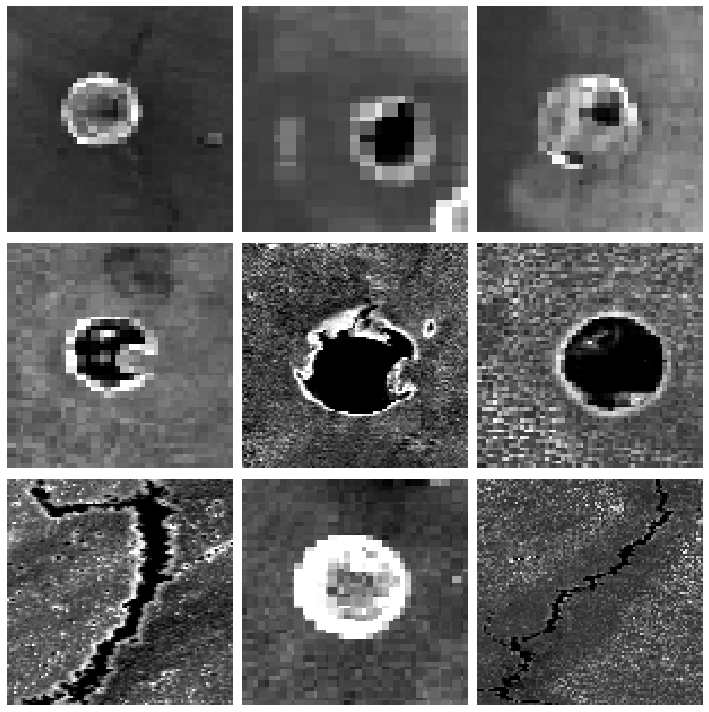

In [13]:
plotImages(sample_training_images[...,0])

In [14]:
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0

In [17]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/20
20/20 [==============================] - 2s 103ms/step - loss: 0.7066 - accuracy: 0.5250 - val_loss: 0.5501 - val_accuracy: 0.5000
Epoch 2/20
20/20 [==============================] - 0s 23ms/step - loss: 0.4683 - accuracy: 0.7850 - val_loss: 0.6120 - val_accuracy: 0.7000
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 0.3663 - accuracy: 0.88 - 1s 26ms/step - loss: 0.3602 - accuracy: 0.8850 - val_loss: 0.2168 - val_accuracy: 0.8000
Epoch 4/20
20/20 [==============================] - 1s 30ms/step - loss: 0.2588 - accuracy: 0.9000 - val_loss: 0.6725 - val_accuracy: 0.7000
Epoch 5/20
20/20 [==============================] - 1s 26ms/step - loss: 0.1526 - accuracy: 0.9500 - val_loss: 0.1095 - val_accuracy: 1.0000
Epoch 6/20
20/20 [==============================] - 1s 28ms/step - loss: 0.0577 - accuracy: 0.9850 - val_loss: 0.1474 - val_accuracy: 0.9000
Epoch 7/20
20/20 [==============================] - 1s 25ms/step - loss: 0.0246 - accuracy: 1.0000 - val_loss: 

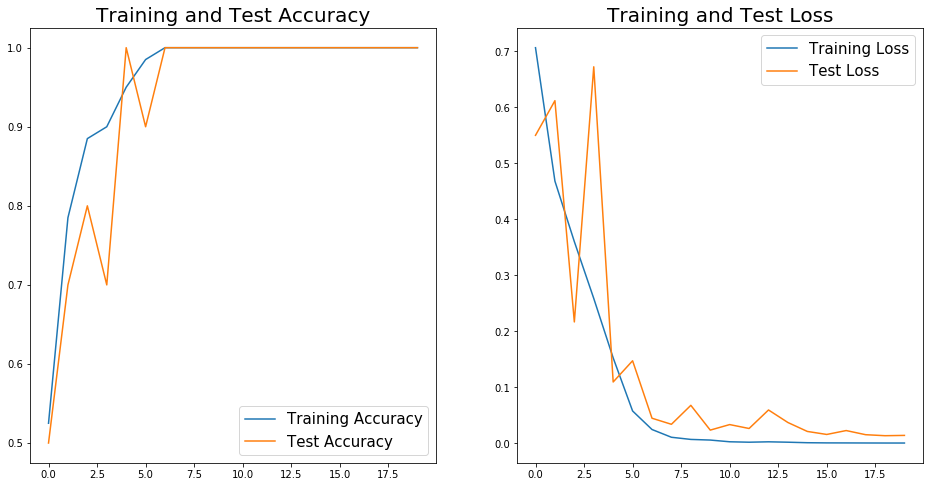

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Test Accuracy')
plt.legend(loc='lower right', fontsize=15)
plt.title('Training and Test Accuracy', size = 20)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right', fontsize=15)
plt.title('Training and Test Loss', size = 20)
plt.show()

In [19]:
# Direct read the images using keras api
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#import cv2

x_pred_dir = os.path.join(PATH, 'Validation_data')
data_path = os.path.join(x_pred_dir,'*g')
files = glob.glob(data_path)
x_pred_data = np.zeros((len(files),IMG_HEIGHT, IMG_WIDTH,1))
for i, f1 in enumerate(files):
    img = load_img(f1, color_mode='grayscale', target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = img_to_array(img)/255.
    x_pred_data[i] = img
x_pred_data.shape

(6, 100, 100, 1)

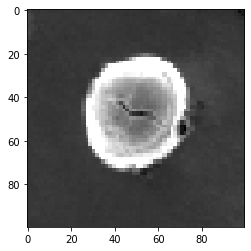

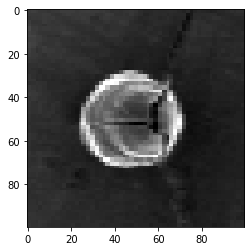

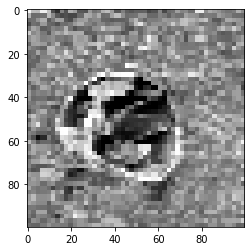

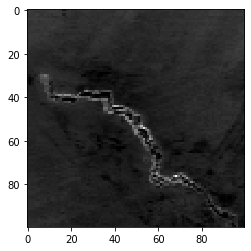

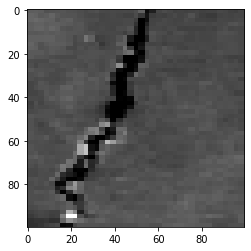

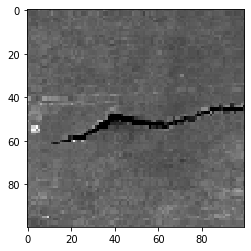

In [23]:
for i in range (6):
    plt.imshow(x_pred_data[i,:,:,0], cmap="gray")
    plt.show()

In [24]:
for i in range (6):
    x_pred=x_pred_data[i]
    result=model.predict(x_pred[None,...])
    if result > 0:
        print('The image contains a pore')
    else:
        print('The image contains a crack')

The image contains a pore
The image contains a pore
The image contains a pore
The image contains a crack
The image contains a crack
The image contains a crack
